In [1]:
%matplotlib inline
import math
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from pandas import ExcelWriter
import pickle

In [2]:
#Read the csv file and modify columns. Returns a dataframe
def tofread_csv(rawdata):
    #read csv file
    data = pd.read_csv(rawdata, error_bad_lines=False)
    #rennaming 1st column as ID
    data = data.rename(index=str, columns= {"Unnamed: 0": "ID"})
    #drop colums that have volume and size\n",
    data = data[data.columns.drop(list(data.filter(regex='vol')))]
    data = data[data.columns.drop(list(data.filter(regex='size')))]
    data.columns = data.columns.str.replace('_mass_g','')
    return data

#non_zero_data drops rows that has a zero value in every isotope returning rows that have particle events. Should be ran first before starting other functions!
def non_zero_data(data):
    #data = data.drop(columns = "ID"),
    non_zero_rows = data.abs().sum(axis=1) > 0.0
    non_zero_data = data[non_zero_rows]
    #non_zero_columns = non_zero_data.abs().sum(axis=0) > 0.0
    #non_zero_data = non_zero_data.loc[: , non_zero_columns]
    return non_zero_data

#wrap the tofread function\n",
def wrapper(string, ELEMENTS = None, new = False):
    df = pd.DataFrame()
    #ELEMENTS = 4\n",
    for i in glob.glob(string):
        df = pd.concat([tofread_csv(i), df], axis = 0, sort = False)
    if new == False:
        df.drop(columns = ['Index', r'timestamp /s'], inplace = True)
        df.columns = df.columns.str.replace(r' /g', '')
        df.columns = df.columns.str.replace('[', '')
        df.columns = df.columns.str.replace('+', '')
        df.columns = df.columns.str.replace(']', '')
    else:
        df.drop(columns = ['Index', r'timestamp (s)'], inplace = True)
        df.columns = df.columns.str.replace(r' (g', '', regex = False)
        df.columns = df.columns.str.replace(r')', '', regex = False)
        df.columns = df.columns.str.replace(r'[', '', regex = False)
        df.columns = df.columns.str.replace('+', '', regex = False)
        df.columns = df.columns.str.replace(']', '', regex = False)
    if ELEMENTS != None:
        df.drop(columns = ELEMENTS, inplace = True)
    return non_zero_data(df)

import copy

#add noise to the data\n",
def addnoise(df, noise, coefficient = None):
    if coefficient != None:
        df = df*coefficient
    df = df.fillna(0) + np.random.random(df.shape)*noise
    return df

#put multiple DFs together with the key
def combineddf(dflist, dfkeys, ELEMENTS, noise = None, coefficient = None):
    #make an empty list
    combinedlist = []
    #make an empty dataframe
    combineddf12 = pd.DataFrame()
    for i,j in zip(dflist, dfkeys):
        if noise == None and coefficient == None:
            df = non_zero_data(i[ELEMENTS])
            #fillnan with 0
            df[np.isnan(df)] = 0
        else:
            #add noise
            df = addnoise(i[ELEMENTS], noise, coefficient)
        df['labels'] = j
        combinedlist.append(df)
        combineddf12 = pd.concat([combineddf12, df])
    return combineddf12

#return random projection codes for each sample
def flyprojection(data, keys, ELEMENTS, expansionfactor):
    data1 = combineddf(data, keys, ELEMENTS)
    sourcenorm = copy.deepcopy(data1.iloc[:,:-1][ELEMENTS])
    #had to center the mean like this because certain elements did not have any particle events for certain sources
    for i in ELEMENTS:
        sourcenorm[i] =sourcenorm[i].fillna(0)
        try:
            sourcenorm[i] = sourcenorm[i]/sourcenorm[i].mean(axis=0)
        except ValueError:
            continue
    sourcenorm = sourcenorm.fillna(0)
    codes1 = encode(np.array(sourcenorm), expansionfactor)
    return codes1

#apply the cluster labels with corresponding max probability
def applylabels(data, keys, ELEMENTS, model, codes):
    data1 = combineddf(data, keys, ELEMENTS)
    labelstransform = model.transform(codes)
    data1['clusters'] = labelstransform.argmax(axis = 1)
    data1['clustersprob'] = labelstransform.max(axis = 1)
    return data1, labelstransform

In [3]:
#import the data
DROPELEMENTS = ['56Fe', '24Mg', '25Mg', '27Al']

#heating
Q16_12_10 = wrapper('sample_data/particle_masses_16_12_10**', DROPELEMENTS)
Q16_12_11 = wrapper('sample_data/particle_masses_16_12_11**', DROPELEMENTS)
Q16_12_12 = wrapper('sample_data/particle_masses_16_12_12**', DROPELEMENTS)
Q16_12_13 = wrapper('sample_data/particle_masses_16_12_13**', DROPELEMENTS)
Q16_12_14 = wrapper('sample_data/particle_masses_16_12_14**', DROPELEMENTS)
Q16_12_15 = wrapper('sample_data/particle_masses_16_12_15**', DROPELEMENTS)
Q16_12_16 = wrapper('sample_data/particle_masses_16_12_16**', DROPELEMENTS)
Q16_12_17 = wrapper('sample_data/particle_masses_16_12_17**', DROPELEMENTS)
Q16_12_18 = wrapper('sample_data/particle_masses_16_12_18**', DROPELEMENTS)
Q16_12_19 = wrapper('sample_data/particle_masses_16_12_19**', DROPELEMENTS)
Q16_12_20 = wrapper('sample_data/particle_masses_16_12_20**', DROPELEMENTS)
Q16_12_21 = wrapper('sample_data/particle_masses_16_12_21**', DROPELEMENTS)
Q16_12_22 = wrapper('sample_data/particle_masses_16_12_22**', DROPELEMENTS)

Qian2016 = [Q16_12_10, Q16_12_11, Q16_12_12, Q16_12_13, Q16_12_14, Q16_12_15, Q16_12_16, Q16_12_17, Q16_12_18, Q16_12_19, Q16_12_20, Q16_12_21, Q16_12_22]
Qian2016keys = ['Q16_12_10', 'Q16_12_11', 'Q16_12_12', 'Q16_12_13', 'Q16_12_14', 'Q16_12_15', 'Q16_12_16', 'Q16_12_17', 'Q16_12_18', 'Q16_12_19', 'Q16_12_20', 'Q16_12_21', 'Q16_12_22']


#Nonheating
Q18_03_06 = wrapper('sample_data/particle_masses_18_03_06**', DROPELEMENTS)
Q18_03_07 = wrapper('sample_data/particle_masses_18_03_07**', DROPELEMENTS)
Q18_03_08 = wrapper('sample_data/particle_masses_18_03_08**', DROPELEMENTS)
Q18_03_09 = wrapper('sample_data/particle_masses_18_03_09**', DROPELEMENTS)
Q18_03_10 = wrapper('sample_data/particle_masses_18_03_10**', DROPELEMENTS)
Q18_03_11 = wrapper('sample_data/particle_masses_18_03_11**', DROPELEMENTS)
Q18_03_12 = wrapper('sample_data/particle_masses_18_03_12**', DROPELEMENTS)
Q18_03_13 = wrapper('sample_data/particle_masses_18_03_13**', DROPELEMENTS)
Q18_03_14 = wrapper('sample_data/particle_masses_18_03_14**', DROPELEMENTS)
Q18_03_15 = wrapper('sample_data/particle_masses_18_03_15**', DROPELEMENTS)

Qian2018 = [Q18_03_06, Q18_03_07, Q18_03_08, Q18_03_09, Q18_03_10, Q18_03_11, Q18_03_12, Q18_03_13, Q18_03_14, Q18_03_15]
Qian2018keys = ['Q18_03_06', 'Q18_03_07', 'Q18_03_08', 'Q18_03_09', 'Q18_03_10', 'Q18_03_11', 'Q18_03_12', 'Q18_03_13', 'Q18_03_14', 'Q18_03_15']


#Urban
QU18_12_02 = wrapper('sample_data/particle_masses_U18_12_02**', DROPELEMENTS)
QU18_12_06 = wrapper('sample_data/particle_masses_U18_12_06**', DROPELEMENTS)
QU18_12_13 = wrapper('sample_data/particle_masses_U18_12_13**', DROPELEMENTS)
QU18_12_14 = wrapper('sample_data/particle_masses_U18_12_14**', DROPELEMENTS)
QU18_12_18 = wrapper('sample_data/particle_masses_U18_12_18**', DROPELEMENTS)
QU18_12_26 = wrapper('sample_data/particle_masses_U18_12_26**', DROPELEMENTS)
QU18_12_28 = wrapper('sample_data/particle_masses_U18_12_28**', DROPELEMENTS)
QU19_01_02 = wrapper('sample_data/particle_masses_U19_01_02**', DROPELEMENTS)

QianU2019 = [QU18_12_02, QU18_12_06, QU18_12_13, QU18_12_14, QU18_12_18, QU18_12_26, QU18_12_28, QU19_01_02]
QianU2019keys = ['QU18_12_02', 'QU18_12_06', 'QU18_12_13', 'QU18_12_14', 'QU18_12_18', 'QU18_12_26', 'QU18_12_28', 'QU19_01_02']


#Rural
QR18_12_02 = wrapper('sample_data/particle_masses_R18_12_02**', DROPELEMENTS)
QR18_12_06 = wrapper('sample_data/particle_masses_R18_12_05**', DROPELEMENTS)
QR18_12_13 = wrapper('sample_data/particle_masses_R18_12_13**', DROPELEMENTS)
QR18_12_14 = wrapper('sample_data/particle_masses_R18_12_14**', DROPELEMENTS)
QR18_12_18 = wrapper('sample_data/particle_masses_R18_12_18**', DROPELEMENTS)
QR18_12_26 = wrapper('sample_data/particle_masses_R18_12_26**', DROPELEMENTS)
QR18_12_28 = wrapper('sample_data/particle_masses_R18_12_28**', DROPELEMENTS)
QR19_01_02 = wrapper('sample_data/particle_masses_R19_01_02**', DROPELEMENTS)

QianR2019 = [QR18_12_02, QR18_12_06, QR18_12_13, QR18_12_14, QR18_12_18, QR18_12_26, QR18_12_28, QR19_01_02]
QianR2019keys = ['QR18_12_02', 'QR18_12_06', 'QR18_12_13', 'QR18_12_14', 'QR18_12_18', 'QR18_12_26', 'QR18_12_28', 'QR19_01_02']


#source samples
soildust = wrapper('sample_data/particle_masses_Source1**', DROPELEMENTS)
condust = wrapper('sample_data/particle_masses_Source2**', DROPELEMENTS)
condsand = wrapper('sample_data/particle_masses_Source3**', DROPELEMENTS)
coalburning = wrapper('sample_data/particle_masses_Source4**', DROPELEMENTS)
indemission = wrapper('sample_data/particle_masses_Source5**', DROPELEMENTS)
urbanfugdust = wrapper('sample_data/particle_masses_Source6**', DROPELEMENTS)

Carexhaust = wrapper('sample_data/particle_masses_car_**', DROPELEMENTS)
Carexhaust_new = wrapper('sample_data/particle_masses_Carexhaust**', DROPELEMENTS, new = True)
biomass = wrapper('sample_data/particle_masses_biomass**', DROPELEMENTS)
biomass_new = wrapper('sample_data/particle_masses_biomas_**', DROPELEMENTS, new = True)


#drop duplicate columns
Carexhaust = Carexhaust.loc[:,~Carexhaust.columns.duplicated()]
Carexhaust = pd.concat([Carexhaust, Carexhaust_new])
biomass = biomass.loc[:,~biomass.columns.duplicated()]
biomass = pd.concat([biomass, biomass_new])


Sourcesamples = [soildust, condust, condsand, coalburning, indemission, Carexhaust, biomass]
Sourcekeys = ['Soil dust', 'Construction dust', 'Construction sand', 'Coal burning', 'Industrial emission', 'Car exhaust', 'Biomass']


#blanks
blank1 = wrapper('sample_data/particle_masses_blank 1**', DROPELEMENTS)
blank2 = wrapper('sample_data/particle_masses_blank 2**', DROPELEMENTS)
blank3 = wrapper('sample_data/particle_masses_blank 3**', DROPELEMENTS)
blank4 = wrapper('sample_data/particle_masses_blank 4**', DROPELEMENTS)
blank5 = wrapper('sample_data/particle_masses_blank 5**', DROPELEMENTS)
blank6 = wrapper('sample_data/particle_masses_blank_**', DROPELEMENTS)

blank = [blank1, blank2, blank3, blank4, blank5, blank6]
blankkeys = ['blank1', 'blank2', 'blank3', 'blank4', 'blank5', 'blank6']

PPFilter1 = wrapper('sample_data/particle_masses_PP Filter 1**', DROPELEMENTS)
PPFilter2 = wrapper('sample_data/particle_masses_PP Filter 2**', DROPELEMENTS)
QuartzFilter1 = wrapper('sample_data/particle_masses_Quartz Filter 1**', DROPELEMENTS)
QuartzFilter2 = wrapper('sample_data/particle_masses_Quartz Filter 2**', DROPELEMENTS)

Filterblank = [PPFilter1, PPFilter2, QuartzFilter1, QuartzFilter2]
Filterblankkeys = ['PPFilter1', 'PPFilter2', 'QuartzFilter1', 'QuartzFilter2']

airkeys = [Qian2016keys, Qian2018keys, QianU2019keys, QianR2019keys, Sourcekeys]
airsection = ['Heating', 'Non-Heating', 'Urban', 'Rural', 'Sources']
airsamples = [Qian2016, Qian2018, QianU2019, QianR2019, Sourcesamples]


ELEMENTS = ['48Ti', '53Cr', '55Mn', '54Fe', '59Co', '60Ni', '63Cu', '64Zn', '69Ga', '72Ge', '75As', '78Se', '85Rb', '88Sr', '89Y', '90Zr', '93Nb', 
           '98Mo', '108Pd', '107Ag', '114Cd', '120Sn', '121Sb', '133Cs', '138Ba', '139La', '140Ce', '152Sm', '153Eu', '158Gd', '159Tb', '164Dy', '165Ho',
           '166Er', '169Tm', '174Yb', '175Lu', '180Hf', '185Re', '192Os', '193Ir', '195Pt', '197Au', '202Hg', '208Pb', '238U', '51V']


<ipython-input-2-aa23f25097a1>:31: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('[', '')
<ipython-input-2-aa23f25097a1>:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('+', '')
<ipython-input-2-aa23f25097a1>:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace(']', '')
<ipython-input-2-aa23f25097a1>:31: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single ch

In [6]:
#returns aggregate particles of a dataset
def aggregate_particles(data, element1 = None):
    total = []
    #go through each row
    for i in data.itertuples():
        labels = []
        #in that row, go through each element
        for j in range(1, len(i)):
            #if there is some value
            if i[j] > 0:
                #append the element into the labels list
                labels.append(data.columns[j - 1])
                #if there is no elements
                if labels[-1] == None:
                    print('ERROR')
        #if there are some elements in the labels list
        if labels != []:
            #append it to the total list
            total.append(labels)
    #make an array of this
    total = np.array(total)
    #only find the unique labels
    uniquelist = np.unique(total)
    
    
    #if element1 is there, focus on that one element
    if element1 != None:
        uniquelist = uniquelist[[element1 in i for i in uniquelist]]
        
    uniquelist1 = []
    #for each unique label
    for i in uniquelist:
        #join them together with a + sign
        uniquelist1.append('+'.join(i))
    totalvalue = []
    # for each unique label
    for i in uniquelist:
        value = 0
        # for each label in total
        for j in total:
            if i == j:
                #count how many there are
                value = value + 1
        totalvalue.append(value)

    finaldf = pd.DataFrame(totalvalue, uniquelist1, columns = ['Value']).sort_values('Value', ascending = False)
    return finaldf


In [7]:
#set each to the specific ELEMENTS
soildust = non_zero_data(soildust[ELEMENTS])
condust = non_zero_data(condust[ELEMENTS])
condsand = non_zero_data(condsand[ELEMENTS])
coalburning = non_zero_data(coalburning[ELEMENTS])
indemission = non_zero_data(indemission[ELEMENTS])
urbanfugdust = non_zero_data(urbanfugdust[ELEMENTS])
Carexhaust = non_zero_data(Carexhaust[ELEMENTS])
biomass = non_zero_data(biomass[ELEMENTS])
#run with biomass and carexhaust
blank6 = non_zero_data(blank6[ELEMENTS])

#reset all the indices
soildust.reset_index(inplace = True, drop = True)
condust.reset_index(inplace = True, drop = True)
condsand.reset_index(inplace = True, drop = True)
coalburning.reset_index(inplace = True, drop = True)
indemission.reset_index(inplace = True, drop = True)
urbanfugdust.reset_index(inplace = True, drop = True)
Carexhaust.reset_index(inplace = True, drop = True)
biomass.reset_index(inplace = True, drop = True)
#blank run with carexhaust and biomass
blank6.reset_index(inplace = True, drop = True)


In [8]:
#merge soil and condust and consand altogether

soilcon = pd.concat([soildust, condust, condsand])

Sourcesamples = [soilcon, coalburning, indemission, Carexhaust, biomass]
Sourcekeys = ['Soil and Construction', 'Coal burning', 'Industrial emission', 'Car exhaust', 'Biomass']

In [9]:
#create a list with same amount of particles for each
Sourcesamplessame = []
for i in Sourcesamples:
    Sourcesamplessame.append(i.sample(np.array([len(i) for i in Sourcesamples]).min(), random_state = 1))

#reset the index
for i in Sourcesamplessame:
    i.reset_index(inplace = True, drop = True)

In [10]:
def split_data(data, percent):
    data_percent = data.iloc[data.sample(frac = percent).index]
    data_rest = data.loc[~data.index.isin(data_percent.index)]
    return data_percent, data_rest

Sourcesamples_training = []
Sourcesamples_testing = []

for i in Sourcesamplessame:
    train, test = split_data(i, 0.8)
    Sourcesamples_training.append(train)
    Sourcesamples_testing.append(test)

In [47]:
rng = np.random.default_rng(seed = 1000)

d = len(ELEMENTS)  # number of features
expansion_factor = 128
m = expansion_factor * d  # dimension of the code space
def top_idx(a, k):
    #indices of the top k values of each row of a
    return np.argpartition(a, -k)[:, -k:]

def top_mask(a, k):
   #create a boolean matrix the same shape as a indicating the top k items of each row
    idx = top_idx(a, k)
    mask = np.zeros_like(a)
    row_idx = np.arange(len(a)).reshape(-1,1)
    mask[np.repeat(row_idx, k, axis=-1), idx] = 1
    return mask

# from the supplementary materials:
# A simple model of M is a sparse, binary random matrix:
# each entry M_ij is set independently with probability p. Choosingp= 6/d, for instance
# would mean that each row of M has roughly 6 entries equal to 1 (and all of the other
# entries are 0), which matches experimental findings.
p = 8 / float(d)
# M is the random mapping from features to codes (in the supplementary materials it is a m x d matrix)
# here it is swapped so we can do data * M = codes where data is n samples x d and codes in n samples x 
M = (rng.random(size=(d, m)) < p).astype(np.uint8)
k = 9 # the k largest values of the code will be used as the result

def encode(data, k):
    #Encode the data using random projection and winner take all approach
    res = data @ M
    mask = top_mask(res, k)
    return res * mask

In [48]:
Sourcecodes = flyprojection(Sourcesamples, Sourcekeys, ELEMENTS, k)
Qian2016codes = flyprojection(Qian2016, Qian2016keys, ELEMENTS, k)
Qian2018codes = flyprojection(Qian2018, Qian2018keys, ELEMENTS, k)
QianU2019codes = flyprojection(QianU2019, QianU2019keys, ELEMENTS, k)
QianR2019codes = flyprojection(QianR2019, QianR2019keys, ELEMENTS, k)

#randomly project training and testing set
Sourcesamples_trainingcodes = flyprojection(Sourcesamples_training, Sourcekeys, ELEMENTS, k)
Sourcesamples_testingcodes = flyprojection(Sourcesamples_testing, Sourcekeys, ELEMENTS, k)

In [49]:
#make an urbfugdust codes
urbfugdustcodes = flyprojection([urbanfugdust], ['Urban fugitive dust'], ELEMENTS, k)

In [50]:
#save object
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [51]:
# Fit and store Model and Codes
#fit the Sourcecodes_training
from sklearn.decomposition import LatentDirichletAllocation

model2 = LatentDirichletAllocation(n_components=10, doc_topic_prior = 0.01)

model2 = model2.fit(Sourcesamples_trainingcodes)

In [25]:
#save model
save_object(model2, 'models/multipleLDAmodels/LDAModel_5.pkl')

#save codes
#save_object(Sourcecodes, 'models/revision_3/Sourcecodes_4.pkl'),
save_object(Sourcesamples_trainingcodes, 'models/multipleLDAmodels/Sourcesamples_trainingcodes_5.pkl')
save_object(Sourcesamples_testingcodes, 'models/multipleLDAmodels/Sourcesamples_testingcodes_5.pkl')
save_object(Qian2016codes, 'models/multipleLDAmodels/Qian2016codes_5.pkl')
save_object(Qian2018codes, 'models/multipleLDAmodels/Qian2018codes_5.pkl')
save_object(QianU2019codes, 'models/multipleLDAmodels/QianU2019codes_5.pkl')
save_object(QianR2019codes, 'models/multipleLDAmodels/QianR2019codes_5.pkl')
save_object(M, 'models/multipleLDAmodels/randommappingfeature.pkl')

In [52]:
#applylabels
Qian2016, Qian2016prob =  applylabels(Qian2016, Qian2016keys, ELEMENTS, model2, Qian2016codes)
Qian2018, Qian2018prob =  applylabels(Qian2018, Qian2018keys, ELEMENTS, model2, Qian2018codes)
QianU2019, QianU2019prob =  applylabels(QianU2019, QianU2019keys, ELEMENTS, model2, QianU2019codes)
QianR2019, QianR2019prob =  applylabels(QianR2019, QianR2019keys, ELEMENTS, model2, QianR2019codes)
Sourcesamples, Sourcesamplesprob =  applylabels(Sourcesamples, Sourcekeys, ELEMENTS, model2, Sourcecodes)
Sourcesamples_training, Sourcesamplesprob_training = applylabels(Sourcesamples_training, Sourcekeys, ELEMENTS, model2, Sourcesamples_trainingcodes)
Sourcesamples_testing, Sourcesamplesprob_testing = applylabels(Sourcesamples_testing, Sourcekeys, ELEMENTS, model2, Sourcesamples_testingcodes)

In [53]:
#add urban fugitive dust
Urbfugdust, Urbfugdustprob = applylabels([urbanfugdust], ['Urban fugitive dust'], ELEMENTS, model2, urbfugdustcodes)

In [54]:
#just the df\r\n",
save_object([Qian2016, Qian2016keys], 'models/multipleLDAmodels/Qian2016DF_5.pkl')
save_object([Qian2018, Qian2018keys], 'models/multipleLDAmodels/Qian2018DF_5.pkl')
save_object([QianU2019, QianU2019keys], 'models/multipleLDAmodels/QianU2019DF_5.pkl')
save_object([QianR2019, QianR2019keys], 'models/multipleLDAmodels/QianR2019DF_5.pkl')
save_object([Sourcesamples_training, Sourcekeys], 'models/multipleLDAmodels/SourcetrainingDF_5.pkl')
save_object([Sourcesamples_testing, Sourcekeys], 'models/multipleLDAmodels/SourcetestingDF_5.pkl')

In [20]:
isotope_matrix = model2.components_ @ np.transpose(M)

In [21]:
isotope_DF = pd.DataFrame(isotope_matrix, columns = ELEMENTS)

<BarContainer object of 47 artists>

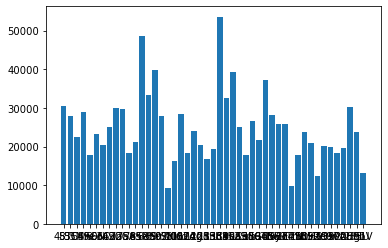

In [22]:
plt.bar(isotope_DF.columns, isotope_DF.loc[0])

In [23]:
element_ranks_list = []
for i in np.arange(0, 20, 1):
    element_ranks_list.append(isotope_DF.loc[i].sort_values(ascending = False)[0:10].index)

pd.DataFrame(element_ranks_list).to_excel('models/revision_2/ranked_elements.xlsx')

In [24]:
# LDA with different parameters
import itertools
#fit the Sourcecodes_training
from sklearn.decomposition import LatentDirichletAllocation


alpha = [0.0001, 0.001, 0.01, 0.1, 0.9]
number_of_clusters = [5, 10, 15, 30, 50]

for j,i in enumerate(itertools.product(alpha, number_of_clusters)):
    model2 = LatentDirichletAllocation(n_components=i[1], doc_topic_prior = i[0])

    model2 = model2.fit(Sourcesamples_trainingcodes)
    #save model \r\n
    save_object([i, model2], 'models/multipleLDAmodels/LDAModelvariant_' + str(j) + '.pkl')